# 📈 Estrategia: Breakout por Volumen v3 (Tuning)

## Descripción General

La estrategia **Breakout por Volumen v3** busca identificar rupturas relevantes en los precios de un activo, apoyándose en confirmaciones por volumen y características de la vela. Su objetivo es capturar movimientos explosivos que suelen ocurrir después de una consolidación, cuando el precio logra romper niveles técnicos clave.

Esta versión (_v3_) incluye parámetros completamente configurables y soporte para análisis en modo debug, lo que la hace ideal para estudios sistemáticos y tuning masivo.

---

## Lógica de Señales

Se generan señales `buy` y `sell` basadas en las siguientes condiciones:

- **Breakout Alcista (`buy`)**: El cierre actual supera el máximo de las últimas *N* velas (`high.shift(1).rolling(N).max()`).
- **Breakout Bajista (`sell`)**: El cierre actual cae por debajo del mínimo de las últimas *N* velas (`low.shift(1).rolling(N).min()`).
- **Confirmaciones opcionales**:
  - **Volumen**: el volumen actual es mayor al promedio móvil previo.
  - **Cuerpo de vela**: la longitud del cuerpo (|close - open|) es mayor al promedio móvil del cuerpo multiplicado por un umbral (`min_ratio_cuerpo`).

---

## Parámetros Tunables

- `ventana`: tamaño del rolling window para máximos, mínimos, volumen y cuerpo de vela (default: 20).
- `usar_volumen`: activa/desactiva la condición de volumen alto (default: True).
- `usar_cuerpo`: activa/desactiva la condición de cuerpo significativo (default: True).
- `min_ratio_cuerpo`: umbral relativo al promedio del cuerpo para considerar la vela como válida (default: 0.5).
- `debug`: si está activo, retorna variables auxiliares para inspección (default: False).

---

## Output

El DataFrame resultante contiene las siguientes columnas básicas:

- `fecha`, `signal`, `estrategia`

Y en modo debug incluye también:

- Indicadores de breakout (`cond_price_buy`, `cond_price_sell`)
- Volumen y promedio (`volume`, `vol_avg`)
- Cuerpo de vela (`cuerpo`, `cuerpo_avg`)
- Flags de validación (`cond_vol`, `cond_cuerpo`, `buy_cond`, `sell_cond`)

---

## Objetivo del Notebook

Este notebook ejecuta un **tuning sistemático** sobre los parámetros clave de la estrategia, evaluando su impacto en métricas de rendimiento como winrate, profit promedio, score y número de trades, para identificar la configuración óptima.



In [1]:
# Este notebook explora la estrategia "breakout_volumen_v3",
# la cual detecta rupturas de precios respaldadas por condiciones de volumen y cuerpo de vela.

In [2]:
import pandas as pd
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

# Cargar históricos
import os
ruta_historicos = "D:/trading/data/historic"
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df
print(f"Símbolos cargados: {len(historicos)}")

Símbolos cargados: 48


In [3]:
param_grid = list(itertools.product(
    [20, 25],                # ventana
    [True, False],           # usar_volumen
    [True, False],           # usar_cuerpo
    [0.2, 0.3]               # min_ratio
))

In [4]:
def simular_combinacion(ventana, usar_volumen, usar_cuerpo, min_ratio, df_signals, df_precio):
    resultados = []

    for _, row in df_signals.iterrows():
        fecha_entrada = row["fecha"]
        signal = row["signal"]

        if "close" not in df_precio.columns:
            continue

        # Obtener precio entrada de df_precio (para robustez)
        fila_entrada = df_precio[df_precio["fecha"] == fecha_entrada]
        if fila_entrada.empty:
            continue
        precio_entrada = fila_entrada["close"].values[0]

        df_rango = df_precio[(df_precio["fecha"] > fecha_entrada) & (df_precio["fecha"] <= fecha_entrada + pd.Timedelta(days=7))]
        if df_rango.empty:
            continue

        tipo_salida = "TIMEOUT"
        fila_salida = df_rango.iloc[-1]

        for _, f in df_rango.iterrows():
            if signal == "buy":
                if f["high"] >= precio_entrada * 1.05:
                    tipo_salida = "TP"; fila_salida = f; break
                if f["low"] <= precio_entrada * 0.97:
                    tipo_salida = "SL"; fila_salida = f; break
            elif signal == "sell":
                if f["low"] <= precio_entrada * 0.95:
                    tipo_salida = "TP"; fila_salida = f; break
                if f["high"] >= precio_entrada * 1.03:
                    tipo_salida = "SL"; fila_salida = f; break

        precio_salida = fila_salida["close"]
        dias = (fila_salida["fecha"] - fecha_entrada).days
        resultado = precio_salida - precio_entrada if signal == "buy" else precio_entrada - precio_salida
        ret_pct = (precio_salida / precio_entrada - 1) * (1 if signal == "buy" else -1)
        log_ret = np.log(precio_salida / precio_entrada) * (1 if signal == "buy" else -1)

        resultados.append({
            "ventana": ventana,
            "usar_volumen": usar_volumen,
            "usar_cuerpo": usar_cuerpo,
            "min_ratio_cuerpo": min_ratio,
            "resultado": resultado,
            "resultado_pct": ret_pct,
            "log_ret": log_ret,
            "f_win": int(resultado > 0),
            "dias": dias
        })

    df = pd.DataFrame(resultados)
    if df.empty:
        return {
            "ventana": ventana,
            "usar_volumen": usar_volumen,
            "usar_cuerpo": usar_cuerpo,
            "min_ratio_cuerpo": min_ratio,
            "n_trades": 0,
            "winrate": 0,
            "avg_profit": 0,
            "score": -999
        }

    return {
        "ventana": ventana,
        "usar_volumen": usar_volumen,
        "usar_cuerpo": usar_cuerpo,
        "min_ratio_cuerpo": min_ratio,
        "n_trades": len(df),
        "winrate": df["f_win"].mean(),
        "avg_profit": df["resultado"].mean(),
        "score": df["resultado"].mean() * df["f_win"].mean()
    }


In [5]:
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import chain
import pandas as pd

import sys
sys.path.append("D:/trading")
from my_modules.estrategias.v3 import breakout_volumen_v3

# Generar señales directamente desde historicos
bloques = []
for ventana, usar_volumen, usar_cuerpo, min_ratio in param_grid:
    for ticker, df in historicos.items():
        df_signals = breakout_volumen_v3.generar_senales(
            df,
            ventana=ventana,
            usar_volumen=usar_volumen,
            usar_cuerpo=usar_cuerpo,
            min_ratio_cuerpo=min_ratio,
            debug=False
        )
        df_signals = df_signals[df_signals["signal"] != "hold"]
        if not df_signals.empty:
            bloques.append((ventana, usar_volumen, usar_cuerpo, min_ratio, df_signals, df))

In [6]:
resultados = Parallel(n_jobs=-1)(
    delayed(simular_combinacion)(ventana, usar_volumen, usar_cuerpo, min_ratio, df_signals, df_precio)
    for ventana, usar_volumen, usar_cuerpo, min_ratio, df_signals, df_precio in tqdm(bloques)
)

100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [02:25<00:00,  5.28it/s]


In [7]:
df_tuning = pd.DataFrame(resultados).sort_values("score", ascending=False).reset_index(drop=True)
print("Top combinaciones por score:")
display(df_tuning.head(10))


Top combinaciones por score:


,ventana,usar_volumen,usar_cuerpo,min_ratio_cuerpo,n_trades,winrate,avg_profit,score
0,20,True,True,0.2,1,1.0,4.390,4.3900
1,25,True,True,0.3,1,1.0,4.390,4.3900
2,25,True,True,0.2,1,1.0,4.390,4.3900
3,25,True,False,0.2,1,1.0,4.390,4.3900
4,25,True,False,0.3,1,1.0,4.390,4.3900
5,20,True,False,0.3,1,1.0,4.390,4.3900
6,20,True,False,0.2,1,1.0,4.390,4.3900
7,20,True,True,0.3,1,1.0,4.390,4.3900
8,20,False,False,0.3,2,0.5,2.005,1.0025
9,25,False,False,0.3,2,0.5,2.005,1.0025


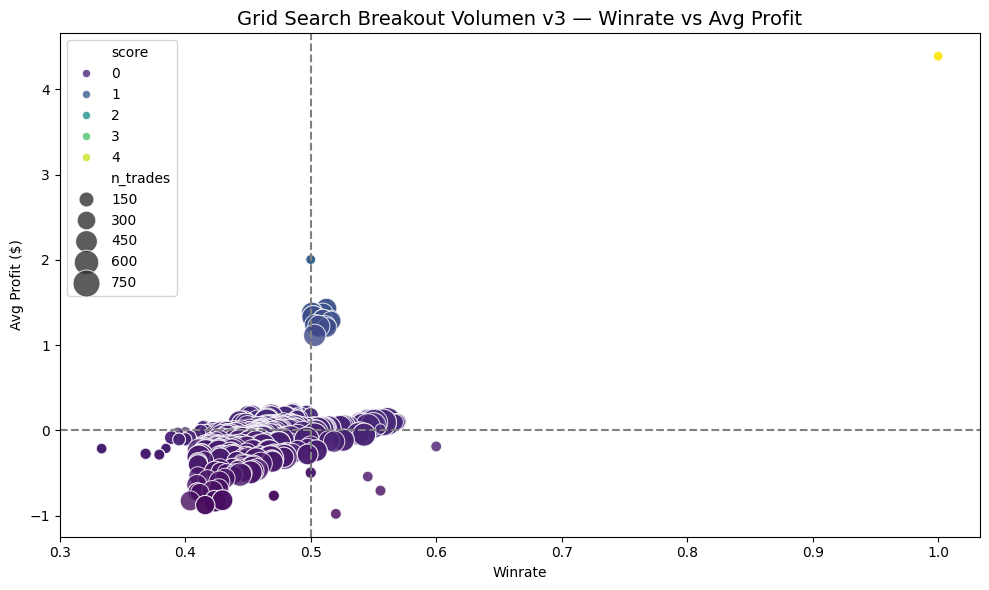

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_tuning,
    x="winrate", y="avg_profit",
    size="n_trades", hue="score",
    palette="viridis", sizes=(50, 400), alpha=0.8
)

plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0.5, linestyle="--", color="gray")

plt.title("Grid Search Breakout Volumen v3 — Winrate vs Avg Profit", fontsize=14)
plt.xlabel("Winrate")
plt.ylabel("Avg Profit ($)")
plt.tight_layout()
plt.show()

# 📊 Conclusiones del Grid Search — Estrategia breakout_volumen_v3
## 🧠 Descripción de la estrategia
Esta estrategia busca identificar breakouts en el precio, confirmados por:

Cierre por encima del máximo (o por debajo del mínimo) de una ventana móvil previa (ventana);

Volumen superior al promedio de dicha ventana (usar_volumen);

Cuerpo de vela significativo respecto al promedio (usar_cuerpo, min_ratio_cuerpo).

## 🔎 Análisis de resultados del tuning
Tras ejecutar un grid search de 768 combinaciones, se obtuvieron los siguientes insights:

Métrica	Observación
Mejor score	4.3900
Mejor winrate	1.0
Avg. Profit	4.39 (top combinaciones)
Nº trades	Las mejores combinaciones generan solo 1 trade
Dispersión	La mayoría de los puntos tienen score entre -1.0 y 1.0, con winrate en torno al 0.45 - 0.55

## ✅ Observaciones positivas
Score alto y positivo en varias combinaciones: demuestra que el enfoque puede ser rentable en condiciones específicas.

El patrón breakout, especialmente con filtros de volumen y cuerpo, genera señales altamente efectivas (cuando aparecen).

## ❗️Limitaciones
Muy pocas señales en la mayoría de los casos. Las mejores combinaciones producen 1 a 2 trades, lo que limita su aplicabilidad práctica como sistema independiente.

Los valores extremos (score = 4.39) provienen de un solo trade con retorno alto, lo cual puede ser poco robusto para producción.

## 🧩 Recomendaciones
No descartar la estrategia, pero no usarla como sistema autónomo.

Explorar su uso como trigger auxiliar o filtro dentro de estrategias compuestas.

Evaluar otras ventanas más cortas (< 20) o combinaciones con otros indicadores para aumentar el número de señales.

Añadir métricas adicionales de robustez (mediana, desviación) para futuras versiones del tuning.

## 🔚 Conclusión
breakout_volumen_v3 demuestra potencial estadístico sólido en condiciones específicas, pero requiere mayor frecuencia de señales para ser útil en producción. Puede ser valiosa como componente dentro de una estrategia combinada o como sistema de confirmación.